## Data Visualization
    Project: Capstone
    Author:  Benedikt Graf
    Version: 11-23-2021

### Import Packages abd Setup Environemnt

In [1]:
import pandas as pd                     # for data handling
import numpy as np                      # for numerical methods and data structures
import latex                            # mathematical expressions  
import re                               # regular expressions
import matplotlib.pyplot as plt         # for plotting
from matplotlib import font_manager     # for advanced fonts
pd.set_option('display.max_rows', 500)

In [2]:
# use Goudy Old Style for figures
font_path = '/Users/bgraf/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/Goudy Old Style Regular.ttf'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

# set global font properties
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams.update({'font.size': 22})
 
#plt.rcParams["font.family"] = "sans-serif"

### Load Raw and Cleaned Data

In [3]:
data_raw = pd.read_stata("./data/tocodeparish/placestocodeparish.dta")
data_clean = pd.read_csv("./data/tocodeparish/cleaned_data.csv", index_col=0)
# Save a copy of orginal birthplace variable

In [4]:
# defining missing values
data_raw["birthcountry"] = data_raw["birthcountry"].replace({'': np.NaN, ' ': np.NaN, 'Unknown': np.NaN, "Sw":"Sweden"})
data_raw["birthcounty"] = data_raw["birthcounty"].replace({'': np.NaN, ' ': np.NaN, 'NA': np.NaN, 'Unknown': np.NaN})
data_raw["ns_birthplace"] = data_raw["ns_birthplace"].replace({'': np.NaN, ' ': np.NaN, 'NA': np.NaN, 'Unknown': np.NaN})
data_raw["birthplace"] = data_raw["birthplace"].replace({'': np.NaN, ' ': np.NaN, 'NA': np.NaN, 'Unknown': np.NaN})

### String Length Statistics (Table 1)

In [5]:
# measure length of strings
data_raw['length']  = data_raw['ns_birthplace'].str.len()
data_clean['length'] = data_clean['ns_birthplace'].str.len()

In [6]:
# (a) measure length of strings before processing
data_raw['length'].describe()

count    758737.000000
mean         29.669722
std           8.978846
min           1.000000
25%          24.000000
50%          28.000000
75%          35.000000
max         124.000000
Name: length, dtype: float64

In [7]:
# (b) measure length of strings after processing
data_clean['length'].describe()

count    130940.000000
mean         32.178402
std           8.387414
min           6.000000
25%          27.000000
50%          32.000000
75%          37.000000
max         120.000000
Name: length, dtype: float64

### Number of Observations (Table 2)


In [11]:
# Pre-processing (a)
total_pre = data_raw.shape[0]
unique_bplace_pre = data_raw.drop_duplicates(subset=['ns_birthplace']).shape[0]
unique_countries_pre = data_raw.drop_duplicates(subset=['birthcountry']).shape[0]
unique_counties_pre = data_raw.drop_duplicates(subset=['birthcounty']).shape[0]

# Post-processing (b)
total_post = data_raw[(data_raw['birthcountry'] == 'Sweden') | 
                      (data_raw["birthcountry"] == "")].reset_index(drop=True)
total_post = total_post.shape[0]
unique_bplace_post = data_clean.shape[0]
unique_countries_post = data_clean.drop_duplicates(subset=['birthcountry']).shape[0]
unique_counties_post = data_clean.drop_duplicates(subset=['birthcounty']).shape[0]

# join all metrics
meta = pd.DataFrame(columns=["Pre", "Post"], data=[[total_pre, total_post],
                                                   [unique_bplace_pre, unique_bplace_post],
                                                   [unique_countries_pre, unique_countries_post],
                                                   [unique_counties_pre, unique_counties_post]])

# includes 1 missing birthcountry and county in each column
meta 

,Pre,Post
0,817130,657579
1,193920,130940
2,135,2
3,35,33


### Histogram of Birthplace String Length (Figure 1)

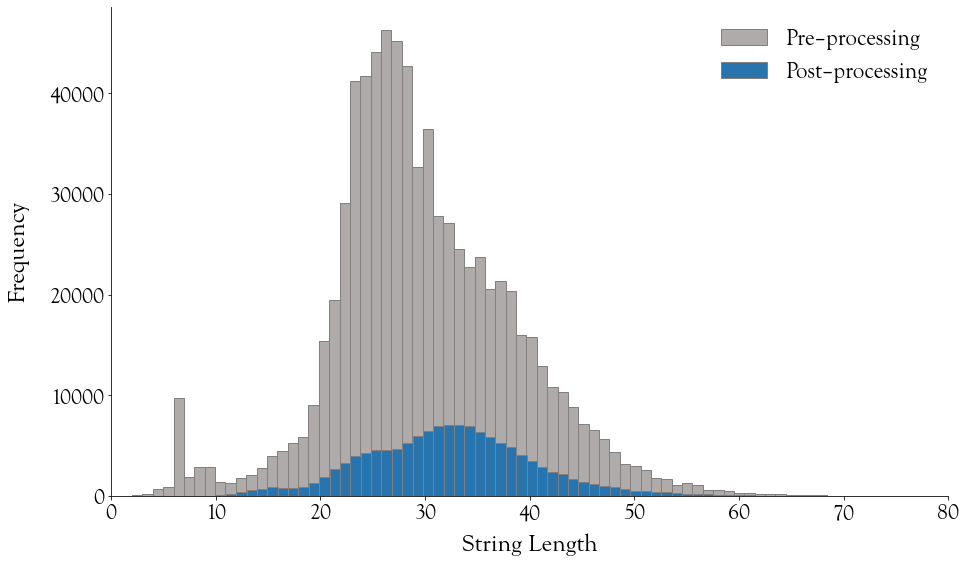

<Figure size 1440x1728 with 0 Axes>

In [12]:
fig, ax = plt.subplots(figsize=(15, 9))

plt.figure(figsize=(20,24))

# plot two lines
l1 = ax.hist(data_raw.length, color='#AFABAB', label="Pre–processing", bins=124, ec="grey")
l2 = ax.hist(data_clean.length, color='#2774AE', label="Post–processing", bins=115, ec="grey")

# axis labels
ax.set_xlabel('String Length', fontsize = 25)
ax.set_ylabel('Frequency', fontsize = 25)

# axis space
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 20

# hide top and right spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# add legend
ax.legend(frameon=False, fontsize = 23)
ax.set_xlim(xmin=0, xmax=80)

#ax.xaxis.set_ticks(np.arange(0, 200000, 40000))

# show plot
plt.show()

### Counties Meta Table (Table 3)

In [13]:
# load two meta tables
parishes_meta = pd.read_csv("./data/geo/parishes_meta.csv")
counties_meta = pd.read_csv("./data/geo/counties_meta.csv")

# merge two meta dataframes
meta_data = pd.merge(parishes_meta, counties_meta[["lan","name"]], left_on="county", right_on="lan")

In [14]:
def geo_sum(data, unit):
    '''
    provides summary statistics on county and parish geography
    "unit" allows for square kilometers (km2) and square miles (mi2)
    '''
    # convert square km to square miles
    if unit == "km2":
        data['area_km2'] = data['area']
        area = "area_km2"
        
    if unit == "mi2":
        data['area_mi2'] = (data['area'] * 0.386102)
        area = "area_mi2"   
     
    # collect metrics
    total = data.groupby("name")[area].sum()
    count = data.groupby("name")[area].count()
    mean = data.groupby("name")[area].mean()
    mini = data.groupby("name")[area].min()
    maxi = data.groupby("name")[area].max()

    # combine metrics
    sum_table = pd.concat((total, count, mean, mini, maxi), axis=1)
    sum_table = pd.DataFrame(sum_table)
    sum_table.columns = ['Total Area', 'Number', 'Mean Area', 'Min. Area', 'Max. Area']
    sum_table = sum_table.round({'Total Area' : 1, 'Mean Area': 1, 'Min. Area': 1, 'Max. Area': 1})
    sum_table.sort_index(inplace=True)

    return(sum_table)

In [15]:
geo_sum(data=meta_data, unit="mi2")

,Total Area,Number,Mean Area,Min. Area,Max. Area
name,,,,,
Blekinge,1162.6,30,38.8,2.7,160.2
Dalarnas,11607.8,54,215.0,4.2,981.1
Gotlands,1217.0,93,13.1,4.2,59.1
Gävleborgs,8113.5,50,162.3,9.3,760.6
Hallands,1905.0,91,20.9,2.7,89.2
Jämtlands,19243.7,54,356.4,5.0,2974.5
Jönköpings,4439.8,132,33.6,0.4,88.8
Kalmar,3976.5,67,59.4,3.1,167.6
Kristianstads,2489.6,146,17.1,0.8,91.5


### Parish Names by County (Reference lists for String-matching)

In [16]:
parishes_meta = pd.read_csv("./data/geo/parishes_meta.csv", index_col=0) 
parishes_meta[parishes_meta.county == 25].sort_values(by="socken")

,geomid,nadkod,grkod,socken,from,tom,area,dedikscb,dedik,forkod,county
87,194,252371001,900,GÄLLIVARE,1742,1961,16942,252371,83220,252371,25
85,182,251803000,900,HIETANIEMI,1617,9999,913,251803,83330,251803,25
81,166,251002002,900,JOKKMOKK,1742,1961,19487,251002,83200,251002,25
96,223,258401001,900,JUKKASJÄRVI,1606,1912,14183,258401,83350,258401,25
97,227,258403000,900,KARESUANDO,1606,9999,6528,258403,83360,258403,25
95,222,258304000,900,KARL GUSTAV (BD-län),1745,9999,484,258304,83310,258304,25
90,203,258003004,900,LULEÅ,1667,1830,4199,258003,83140,258003,25
89,197,258001001,900,LULEÅ STADS,1667,1961,110,258001,83150,258001,25
83,172,251401002,900,NEDERKALIX,1637,1908,1936,251401,83180,251401,25
94,221,258301000,900,NEDERTORNEÅ-HAPARANDA,1745,9999,473,258301,83290,258301,25
